In [1]:
import xgboost as xgb
from scipy import stats
from BookDataset import preprocess, categoricalToIndices
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')


train = preprocess(train, isTrain=True, transforms=False)
test = preprocess(test, isTrain=False, transforms=False)

categoricalToIndices(train, None, test)
train.head()

,Author,Genre,BookCategory,Reviews,Ratings,Edition,Price
0,0,2,1,4.0,8.0,0,220.000000
1,37,50,3,3.9,14.0,0,202.929993
2,0,126,7,4.8,6.0,0,299.000000
3,8,64,6,4.1,13.0,0,180.000000
4,0,157,2,5.0,1.0,1,965.619995


In [3]:
param_grid = {
    'colsample_bytree': [1., .5, .7, .3, .1],
    'n_estimators': [50],
    'max_depth': [7, 10, 15, 20],
}

model = xgb.XGBRegressor()
searcher = GridSearchCV(param_grid=param_grid, estimator=model,
            scoring='neg_mean_squared_error', cv=4, verbose=1)


# Fit grid_mse to the data
X, y = train.iloc[:, :-1], train.iloc[:,-1].apply(lambda x: np.log(x+ 1))
searcher.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", searcher.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(searcher.best_score_)))

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   35.6s finished
Best parameters found:  {'colsample_bytree': 0.5, 'max_depth': 7, 'n_estimators': 50}
Lowest RMSE found:  0.6105413474973237


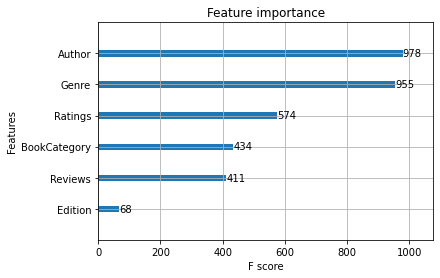

In [4]:
model = xgb.XGBRegressor(**searcher.best_params_)
model.fit(X, y)
xgb.plot_importance(model);

In [5]:
preds = model.predict(X)
err = preds - y
err = np.mean(err**2)
print("MSE", err)

MSE 0.2214375717780346


In [6]:
filename = 'xgboost_gridcv.xlsx'
preds = model.predict(test)
preds = np.exp(preds) - 1
submission = pd.DataFrame({'Price': preds})
submission.to_excel(filename, index=False)
print("Saved file to", filename, 'with shape', submission.shape)

Saved file to xgboost_gridcv.xlsx with shape (1560, 1)
